# Analyzing Financial and Economic Variables with FOMC sentiment

Alexander Ng

This section loads, imputes missing values and constructs the time series of returns or indices for regression and comparison with the sentiment indicator.

The section also demonstrates the regression between sentiment and financial or macroeconomic variables.


## Data Source

We consider 4 financial time series from the FRED database which represent interest rates, credit, inflation and equity markets.

*  **BAA10Y**, Moody's Seasoned Baa Corporate Bond yield relative to yield on 10-year Treasury Constant Maturities.  

*  **T10YIE**, the breakeven inflation rate represents the expected inflation derived from 10-Year Treasury constant maturity securities minus the 10-Year Treasury Inflation-Indexed Constant Maturity index.  It represents market expectations of average inflation over the next 10 years.

*  **WILL5000IND**, the total returns of the Wilshire 5000 Stock Index, observed daily, including reinvested dividends.  This is a broad measure of the entire US stock market.

*  **DGS10**, the yield on 10-year Treasury Constant Maturities.

Each of the above financial time series is observed at daily interval and reflected the values at market close 4pm EST.

We consider 3 macroeconomic variables which are published at monthly frequency for the US economy.  These are also sourced from the FRED database.

*  **UNRATE**, the U-3 measure of labor unemployment as published monthly by the Bureau of Labor Statistics (BLS), expressed as a percentage of the labor force of people 16 years of age or older, who are not in institutions or active military duty.  This statistic is reported for the prior month.

*  **CIVPART**, the Labor Force Participation Rate, measures the percentage of people in the labor force as a percentage of population of civilian noninstitutionalized people.

*  **PCEPILFE**, the Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), indexed to 2012=100, is the preferred measure by the FOMC of price increases in the US.   It is a measure of the price paid for goods and services in the US.  It measures actual inflation on a backward looking basis.

We do NOT consider real GDP as an regression variable for several important reasons:

*  GDP is published quarterly, but FOMC sentiment is published every 6-8 weeks.  Thus, sentiment will change regardless of the prior GDP quarterly figure.   The mismatch in periodicity cannot easily be resolved.

*  GDP is updated 3 times as an initial release, secondary and third release.   Each release includes more complete information to estimate Gross Domestic Product.  While each revision is known to influence markets, the value of each revision is serially correlated to earlier releases.  

*  GDP release schedules don't follow a simple chronological pattern.


## Cleaning the Data

We process each FRED time series but forward filling each missing value.  Missing values occur on market holidays.
Thus, forward filling avoids backtest look-ahead bias.  We also need to coerce the data series from string to numeric which is done using `pandas.to_numeric()` call.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from pandas import read_csv

fred_dir = "../fred/"

def process_fred_dateseries( csv_file, series_name ):

#  header = 0  the header row is located at row index 0
#  parse_dates - dates are at column index 0
#  index_col  -  first column is the index for the Time Series object
#
# ----------------------------------------------------
    
    df = pd.read_csv(csv_file, header = 0, parse_dates = [0], index_col = 0 )
    
    # convert blank or missing data to nan and other values from string to numeric
    df[series_name] = pd.to_numeric( df[series_name], errors = 'coerce')
    
    # Fill forward any missing data on a business holiday.
    #
    df.fillna( method = "ffill", inplace = True )
    
    df.reset_index(inplace=True)
    
    return df

#
#   Series filenames are <SERIES-KEY>.csv
#
#   Series file content:  <date>, <series-key>
# ----------------------------------------------------------------------------
def load_and_display_fred_dateseries( series_list , show_plot = False):
    
    dict_series = { }
    
    for series in series_list:
    
        sfilename = fred_dir + series + ".csv"
        
        df_series = process_fred_dateseries( sfilename, series)
        
        dict_series.update({ series : df_series } )
        
        if show_plot:
            df_series.plot( y = series )
            plt.show()
        
    return dict_series


When we run the above function on our list of FRED time series, the function returns the cleansed, imputed data series in a single object - a dictionary.

That dictionary contains a sequence of key-value pairs:

*  `key`:  the series name 

*  `value`:  pandas DataFrame whose column is the imputed data value as the series.

In addition, when we set the parameter `show_plot` = `True`, we obtain a time series plot of each series as a side-effect.


In [21]:
#
#  All the data series to be used in regression analysis.  
# -------------------------------------------------------------------------------------------
series_list = ["BAA10Y", "T10YIE", "WILL5000IND", "DGS10", "UNRATE","CIVPART",   "PCEPILFE"]

#
# Store the data series in a dictionary with:
#    key:   series key
#    value: DataFrame of dates, raw time series valuees
# 
dict_series = load_and_display_fred_dateseries(series_list, show_plot = False)


## Time Dynamics

The FOMC meetings occur at 2pm EST.   We generate a series of returns for each financial variable and changes for each economic variable.

We will check if FOMC sentiment appears to influence future changes in financial markets.
For the financial variables, we consider percentage changes at 2-day and 5-day intervals.   These changes will be regressed against changes in FOMC sentiment to detect relationships.   

We will check if FOMC sentiments appears to be influenced by past changes in economic variables.
We will measure monthly changes in personal consumption, unemployment and labor participation rates and see if past changes appear to influence future changes in FOMC sentiment.

Additional data columns are appended to the dataframe of each series within the series dictionary object.   

We also visualize each resultant time series of returns along with the original time series.

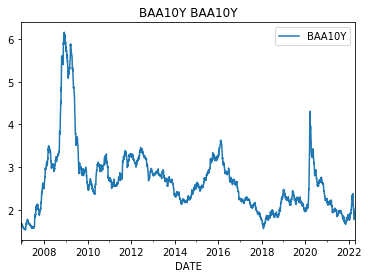

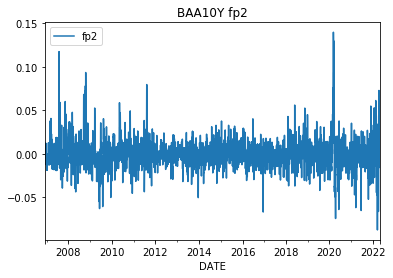

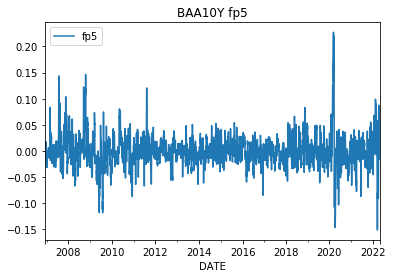

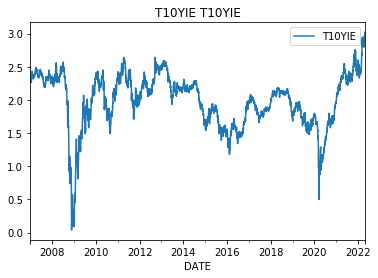

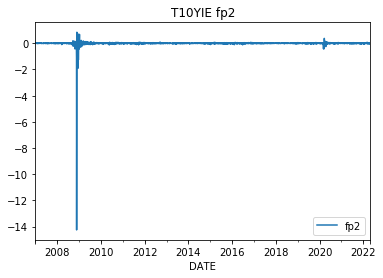

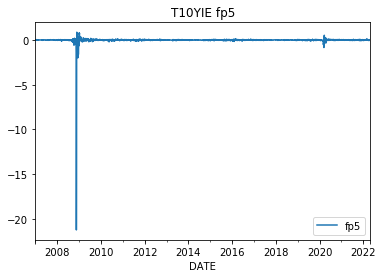

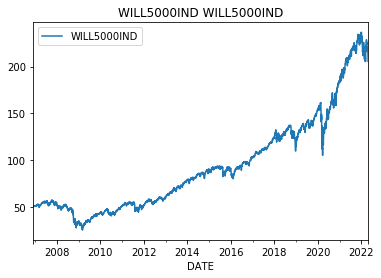

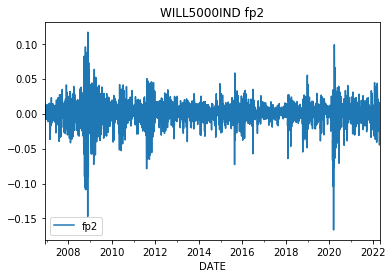

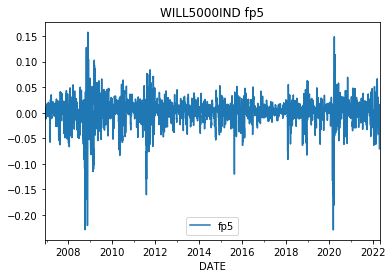

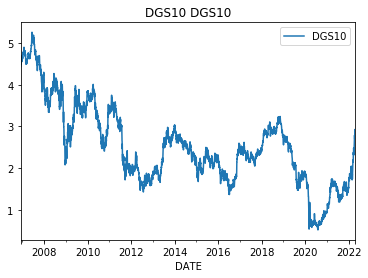

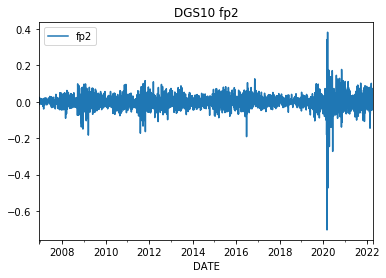

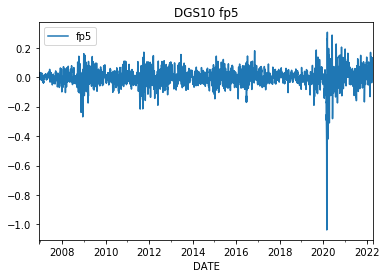

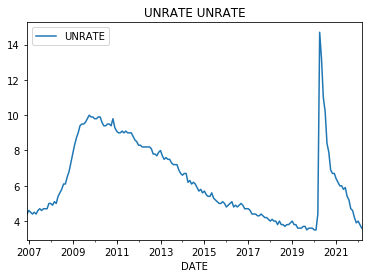

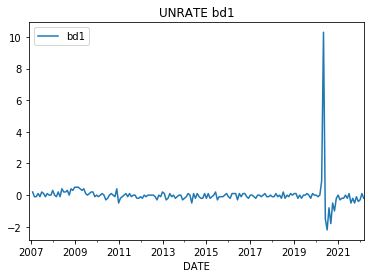

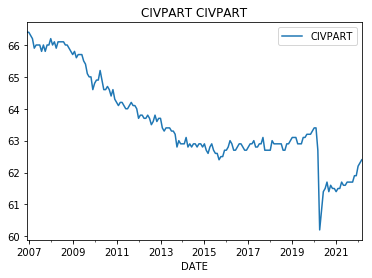

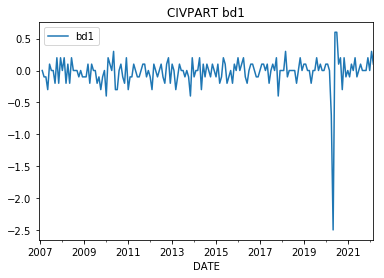

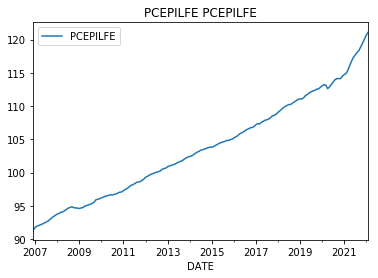

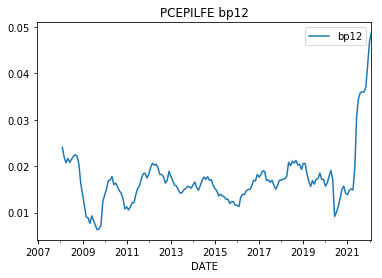

In [22]:


def transform_fred_dateseries( series_dict, series_key, period, is_pct , col_name , forward_shift = 1):
    
    df_series = series_dict[ series_key]
    
    if is_pct:
        df_series[ col_name ] = df_series[series_key].pct_change( periods = period )
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift
    else:
        df_series[ col_name ] = df_series[series_key].diff( periods = period )
        
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift

transform_fred_dateseries( dict_series, "BAA10Y", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "BAA10Y", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "T10YIE", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "T10YIE", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "WILL5000IND", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "WILL5000IND", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "DGS10", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "DGS10", -5,  is_pct = True, col_name = "fp5")

#
# Look back 1 month for Labor Participation Rate.  Use absolute rate change.
# 
# Join the monthly FOMC meeting to the same-month-CIVPART value and compare:
# sentiment Y of the FOMC and its prior-period change dY vs.  bd1 of the same-month-CIVPART 
#  
# Check if bd1 predicts dY
transform_fred_dateseries( dict_series, "CIVPART", 1,  is_pct = False, col_name = "bd1")

# Join the monthly FOMC meeting to the same-month-UNRATE value and compare:
# sentiment Y of the FOMC and its prior-period change dY vs.  bd1 of the same-month-UNRATE
#  
# Check if bd1 predicts dY
transform_fred_dateseries( dict_series, "UNRATE", 1,  is_pct = False, col_name = "bd1")

#
#  PCEPILFE is released monthly on a backward looking basis near the end of the following month.
#  E.g.
#        PCE[ Jan 2022] is published late Feb 2022 and would be available for an March 2022 FOMC meeting.
#
#  So we would shift the 12 month change in Jan 2022 PCEILFE to March 2022 bp12 data point.
#  i.e. use a 2 month forward shift
#
#  Regress if bp12 predicts change in sentiment dY
transform_fred_dateseries( dict_series, "PCEPILFE", 1,  is_pct = True, col_name = "bp12", forward_shift = 2)


#
# Display plots of all the time series and their transforms.
# 
# Outer loop is the series key
for v in dict_series:
    
    # inner loop is all data columns
    # only works if date is an index - not a column
    for u in dict_series[v]:
        
        if u != "DATE":
            dict_series[v].plot( x = "DATE", y = u)
            plt.title(v + " " + u)
            plt.show()


## Specifying the Regressions

We implement the dataframes containing the variables to be regressed below.

* The sentiment indicator is put into a dataframe called `df_sentiment`

* The market variables to be regressed are aligned by date.

We use the pandas `merge_asof` to do approximate date matching correctly.
Its logic aligns each FOMC date to the closest prior date of each other published financial or economic time series. 

Each univariate regression is displayed below for analysis using a scatter plot.

$\color{red}{\text{Note that the sentiment analysis is artificial in this example and should be replaced by the actual data.}}$



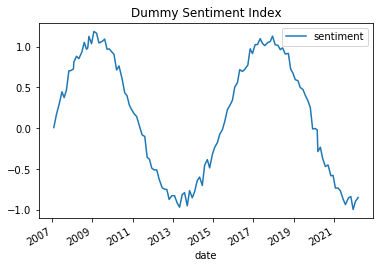

          date  sentiment  d1sentiment       DATE  CIVPART  bd1
115 2021-01-27  -0.732960    -0.154413 2021-01-01     61.4  0.0
116 2021-03-17  -0.733277    -0.000317 2021-03-01     61.5  0.1
117 2021-04-28  -0.768108    -0.034831 2021-04-01     61.7  0.0
118 2021-06-16  -0.868475    -0.100367 2021-06-01     61.6 -0.1
119 2021-07-28  -0.935528    -0.067053 2021-07-01     61.7  0.0
120 2021-09-22  -0.853021     0.082507 2021-09-01     61.7  0.0
121 2021-11-03  -0.836731     0.016290 2021-11-01     61.9  0.0
122 2021-12-15  -0.995892    -0.159162 2021-12-01     61.9  0.2
123 2022-01-26  -0.895558     0.100335 2022-01-01     62.2  0.0
124 2022-03-16  -0.848892     0.046666 2022-03-01     62.4  0.1


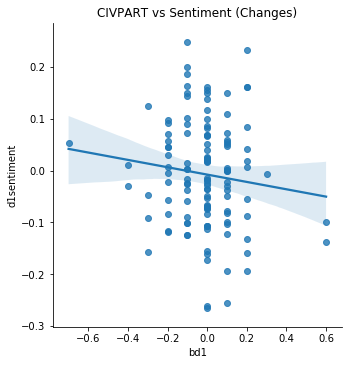

          date  sentiment  d1sentiment       DATE  UNRATE  bd1
115 2021-01-27  -0.732960    -0.154413 2021-01-01     6.4  0.0
116 2021-03-17  -0.733277    -0.000317 2021-03-01     6.0 -0.2
117 2021-04-28  -0.768108    -0.034831 2021-04-01     6.0 -0.2
118 2021-06-16  -0.868475    -0.100367 2021-06-01     5.9 -0.2
119 2021-07-28  -0.935528    -0.067053 2021-07-01     5.4  0.1
120 2021-09-22  -0.853021     0.082507 2021-09-01     4.7 -0.2
121 2021-11-03  -0.836731     0.016290 2021-11-01     4.2 -0.1
122 2021-12-15  -0.995892    -0.159162 2021-12-01     3.9 -0.4
123 2022-01-26  -0.895558     0.100335 2022-01-01     4.0 -0.3
124 2022-03-16  -0.848892     0.046666 2022-03-01     3.6 -0.2


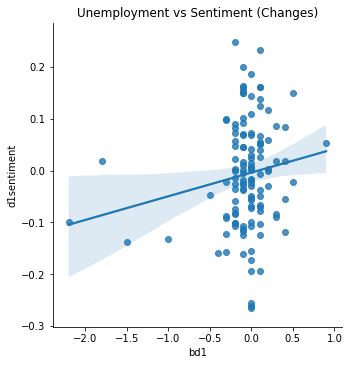

          date  sentiment  d1sentiment       DATE  PCEPILFE      bp12
115 2021-01-27  -0.732960    -0.154413 2021-01-01   114.746  0.013840
116 2021-03-17  -0.733277    -0.000317 2021-03-01   115.383  0.015092
117 2021-04-28  -0.768108    -0.034831 2021-04-01   116.100  0.014874
118 2021-06-16  -0.868475    -0.100367 2021-06-01   117.327  0.030827
119 2021-07-28  -0.935528    -0.067053 2021-07-01   117.704  0.034573
120 2021-09-22  -0.853021     0.082507 2021-09-01   118.357  0.036036
121 2021-11-03  -0.836731     0.016290 2021-11-01   119.483  0.037028
122 2021-12-15  -0.995892    -0.159162 2021-12-01   120.092  0.041862
123 2022-01-26  -0.895558     0.100335 2022-01-01   120.681  0.046866
124 2022-03-16  -0.848892     0.046666 2022-02-01   121.108  0.048893


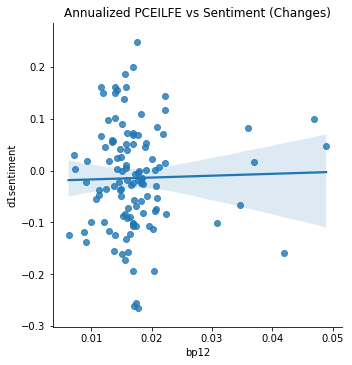

          date  sentiment  d1sentiment       DATE  BAA10Y       fp2       fp5
115 2021-01-27  -0.732960    -0.154413 2021-01-27    2.16  0.004608  0.009174
116 2021-03-17  -0.733277    -0.000317 2021-03-17    2.23 -0.009217 -0.037915
117 2021-04-28  -0.768108    -0.034831 2021-04-28    1.98 -0.000000 -0.000000
118 2021-06-16  -0.868475    -0.100367 2021-06-16    1.91 -0.065217 -0.031579
119 2021-07-28  -0.935528    -0.067053 2021-07-28    1.96 -0.005155  0.010152
120 2021-09-22  -0.853021     0.082507 2021-09-22    1.83 -0.011050 -0.016667
121 2021-11-03  -0.836731     0.016290 2021-11-03    1.70  0.011561 -0.023952
122 2021-12-15  -0.995892    -0.159162 2021-12-15    1.83  0.026738  0.031915
123 2022-01-26  -0.895558     0.100335 2022-01-26    1.84 -0.026882  0.005208
124 2022-03-16  -0.848892     0.046666 2022-03-16    2.23 -0.087558 -0.151220


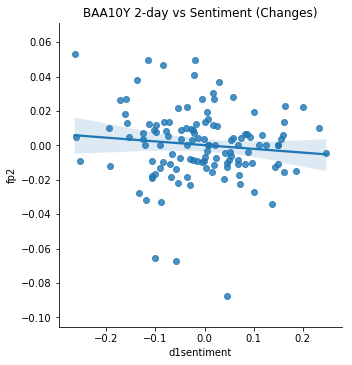

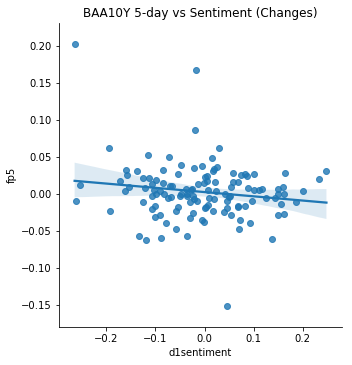

          date  sentiment  d1sentiment       DATE  T10YIE       fp2       fp5
115 2021-01-27  -0.732960    -0.154413 2021-01-27    2.08  0.023474  0.032558
116 2021-03-17  -0.733277    -0.000317 2021-03-17    2.30 -0.013216 -0.004367
117 2021-04-28  -0.768108    -0.034831 2021-04-28    2.41  0.012397  0.012397
118 2021-06-16  -0.868475    -0.100367 2021-06-16    2.32 -0.048458 -0.030303
119 2021-07-28  -0.935528    -0.067053 2021-07-28    2.41  0.020576 -0.000000
120 2021-09-22  -0.853021     0.082507 2021-09-22    2.28  0.008658  0.037815
121 2021-11-03  -0.836731     0.016290 2021-11-03    2.53  0.019531  0.045627
122 2021-12-15  -0.995892    -0.159162 2021-12-15    2.39  0.020661  0.028689
123 2022-01-26  -0.895558     0.100335 2022-01-26    2.38 -0.004167  0.008230
124 2022-03-16  -0.848892     0.046666 2022-03-16    2.80  0.024055  0.024055


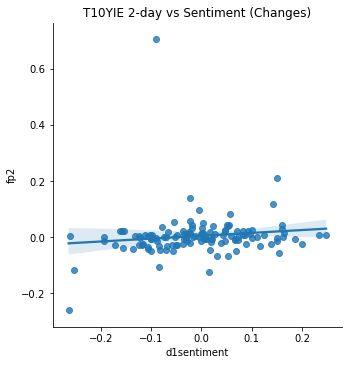

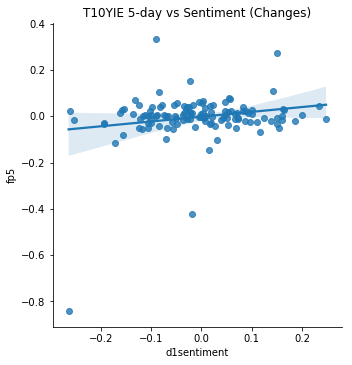

          date  sentiment  d1sentiment       DATE  WILL5000IND       fp2  \
115 2021-01-27  -0.732960    -0.154413 2021-01-27       186.54 -0.016461   
116 2021-03-17  -0.733277    -0.000317 2021-03-17       198.70 -0.014079   
117 2021-04-28  -0.768108    -0.034831 2021-04-28       208.43  0.004440   
118 2021-06-16  -0.868475    -0.100367 2021-06-16       210.50 -0.005610   
119 2021-07-28  -0.935528    -0.067053 2021-07-28       218.28  0.005291   
120 2021-09-22  -0.853021     0.082507 2021-09-22       218.58  0.021919   
121 2021-11-03  -0.836731     0.016290 2021-11-03       232.27  0.010770   
122 2021-12-15  -0.995892    -0.159162 2021-12-15       231.90  0.005751   
123 2022-01-26  -0.895558     0.100335 2022-01-26       213.26 -0.010061   
124 2022-03-16  -0.848892     0.046666 2022-03-16       214.70  0.036402   

          fp5  
115 -0.003670  
116 -0.018459  
117 -0.008902  
118  0.000567  
119  0.005019  
120  0.000877  
121  0.012845  
122  0.005448  
123  0.041978  
124

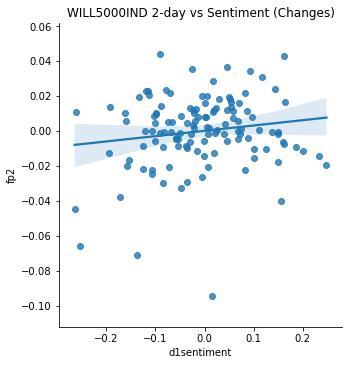

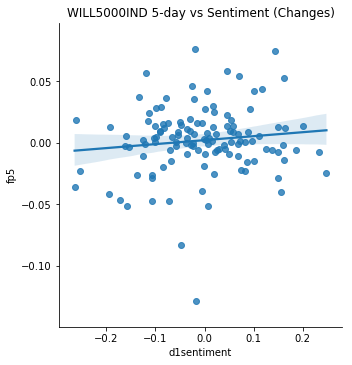

          date  sentiment  d1sentiment       DATE  DGS10       fp2       fp5
115 2021-01-27  -0.732960    -0.154413 2021-01-27   1.04  0.018692  0.062500
116 2021-03-17  -0.733277    -0.000317 2021-03-17   1.63  0.052632  0.006135
117 2021-04-28  -0.768108    -0.034831 2021-04-28   1.63  0.012121 -0.012422
118 2021-06-16  -0.868475    -0.100367 2021-06-16   1.57  0.006579 -0.020270
119 2021-07-28  -0.935528    -0.067053 2021-07-28   1.26  0.023438 -0.050420
120 2021-09-22  -0.853021     0.082507 2021-09-22   1.32  0.056738  0.136364
121 2021-11-03  -0.836731     0.016290 2021-11-03   1.60 -0.019608 -0.068493
122 2021-12-15  -0.995892    -0.159162 2021-12-15   1.47 -0.000000  0.027027
123 2022-01-26  -0.895558     0.100335 2022-01-26   1.85  0.016575  0.016575
124 2022-03-16  -0.848892     0.046666 2022-03-16   2.19  0.022727  0.096639


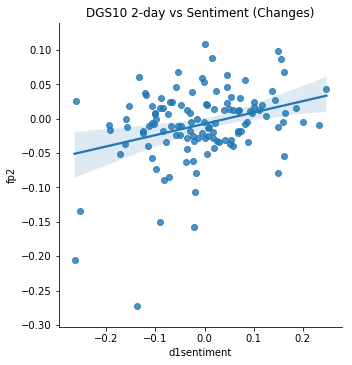

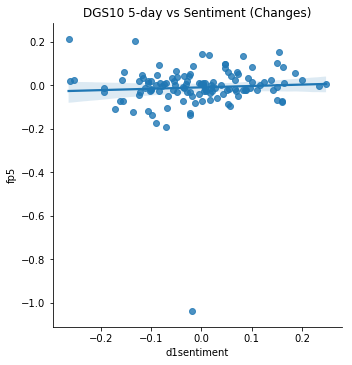

In [24]:

#
# Load the FOMC dates and make dummy sentiment index values
#
derived_data_dir = "../derived"

fomc_statements_file = derived_data_dir + "/" + "FOMC_statements.csv"

df_fomc_statements_raw = pd.read_csv( fomc_statements_file , parse_dates=[1], header = 0)

#  Construct a sentiment dates dataframe with dummy values
#  made using a random number generator.
# ------------------------------------------------------
num_fomc_dates = len(df_fomc_statements_raw)

np.random.seed(1029)

df_sentiment = pd.DataFrame( df_fomc_statements_raw["date"] )

df_sentiment["sentiment"] = np.sin( 0.09 * np.arange( num_fomc_dates ) ) +  0.2 * np.random.rand(num_fomc_dates)

df_sentiment.plot(x = "date", y = "sentiment")
plt.title("Dummy Sentiment Index")
plt.show()

df_sentiment[ "d1sentiment" ] = df_sentiment["sentiment"].diff( periods = 1 )

#
#  Merge dates of the Sentiment and Market Indicator to construct a regression.
#
#  Let sentiment variable be denoted Z
#  
#  For macroeconomic variables Y:   we estimate the model  Z = f(Y).   Explain sentiment in terms of macroeconomic variable.
#
#  For financial market variable X:  we estimate the model X = g(Z).  Explain financial variable in terms of sentiment variable.
#
#  Date Alignment for macroeconomic model fit:
#      for each FOMC date f(i) and the prior FOMC meeting date f(i-1) 
#           find the macroeconomic variable for the same month and year.
#
#      Estimate a model based on the change in sentiment Z[f(i)] - Z[f(i-1)]
#
#      Compare to the prior change in macroeconomic bd1 (backward difference 1 lag) or 
#      bp12 (backward proportional change 12 months)
# -------------------------------------------------------------------

CIVPART = dict_series["CIVPART"]

df_sent_CIVPART = pd.merge_asof(df_sentiment, CIVPART, left_on = "date", right_on = "DATE")

print(df_sent_CIVPART.tail(10) )

sns.lmplot( y= 'd1sentiment', x = "bd1", data = df_sent_CIVPART, fit_reg=True, legend=True)
plt.title("CIVPART vs Sentiment (Changes)")
plt.show()


UNRATE = dict_series["UNRATE"]

df_sent_UNRATE = pd.merge_asof(df_sentiment, UNRATE, left_on = "date", right_on = "DATE")

print(df_sent_UNRATE.tail(10) )

sns.lmplot( y= 'd1sentiment', x = "bd1", data = df_sent_UNRATE, fit_reg=True, legend=True)

plt.title("Unemployment vs Sentiment (Changes)")
plt.show()



PCEPILFE = dict_series["PCEPILFE"]

df_sent_PCEPILFE = pd.merge_asof(df_sentiment, PCEPILFE, left_on = "date", right_on = "DATE")

print(df_sent_PCEPILFE.tail(10) )

sns.lmplot( y= 'd1sentiment', x = "bp12", data = df_sent_PCEPILFE, fit_reg=True, legend=True)

plt.title("Annualized PCEILFE vs Sentiment (Changes)")
plt.show()

#  Date Alignment for financial model fit:
#      for each FOMC date f(i):
#           find the financial variable for the date.  Most variables are available daily.
#
#      Estimate a model on the change in the financial variable as a result of the change in sentiment.
#
#      One important problem is that FOMC statement is released during the market hours at 2pm EST.
#      Thus, the financial variable recorded at end of day on the same day as the FOMC statement already reflects
#      the sentiment impact.
#      Therefore, we need to compare the change in response of the financial variable across
#      a date before the FOMC statement versus 1 or more days after the FOMC statement.
#
#      We use 2 comparison periods to measure the change:
#          bp2:   change from 1 day before FOMC date to 1 day AFTER FOMC date
#          bp5:   change from 1 day before FOMC date to 4 days AFTER FOMC date
#      For ease of date alignment, we shifted both bp2 and bp5 by 1 day forward.
#      So the value of bp2 and bp5 on a FOMC date is actually spanning the intended time period.
# ----------------------------------------------------------

BAA10Y = dict_series["BAA10Y"]

df_sent_BAA10Y = pd.merge_asof(df_sentiment, BAA10Y, left_on = "date", right_on = "DATE")

print(df_sent_BAA10Y.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_BAA10Y, fit_reg=True, legend=True)

plt.title("BAA10Y 2-day vs Sentiment (Changes)")
plt.show()


sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_BAA10Y, fit_reg=True, legend=True)

plt.title("BAA10Y 5-day vs Sentiment (Changes)")
plt.show()


T10YIE = dict_series["T10YIE"]

df_sent_T10YIE = pd.merge_asof(df_sentiment, T10YIE, left_on = "date", right_on = "DATE")

print(df_sent_T10YIE.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_T10YIE, fit_reg=True, legend=True)

plt.title("T10YIE 2-day vs Sentiment (Changes)")
plt.show()


sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_T10YIE, fit_reg=True, legend=True)

plt.title("T10YIE 5-day vs Sentiment (Changes)")
plt.show()



WILL5000IND = dict_series["WILL5000IND"]

df_sent_WILL5000IND = pd.merge_asof(df_sentiment, WILL5000IND, left_on = "date", right_on = "DATE")

print(df_sent_WILL5000IND.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_WILL5000IND, fit_reg=True, legend=True)

plt.title("WILL5000IND 2-day vs Sentiment (Changes)")
plt.show()


sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_WILL5000IND, fit_reg=True, legend=True)

plt.title("WILL5000IND 5-day vs Sentiment (Changes)")
plt.show()



DGS10 = dict_series["DGS10"]

df_sent_DGS10 = pd.merge_asof(df_sentiment, DGS10, left_on = "date", right_on = "DATE")

print(df_sent_DGS10.tail(10) )

sns.lmplot( x= 'd1sentiment', y = "fp2", data = df_sent_DGS10, fit_reg=True, legend=True)

plt.title("DGS10 2-day vs Sentiment (Changes)")
plt.show()


sns.lmplot( x= 'd1sentiment', y = "fp5", data = df_sent_DGS10, fit_reg=True, legend=True)

plt.title("DGS10 5-day vs Sentiment (Changes)")
plt.show()